# Introduction

![Porto Seguro Auto](https://segurodecarroaqui.com.br/wp-content/uploads/2017/12/sulamerica-seguro-auto.png)

This notebook starts by giving an introduction in the data of Porto Seguro competition.  Then follows with preparing and running few predictive models using cross-validation and stacking and prepares a submission.

The notebook is using elements from the following kernels:
* [Data Preparation and Exploration](https://www.kaggle.com/bertcarremans/data-preparation-exploration) by Bert Carremans.  
* [Steering Whell of Fortune - Porto Seguro EDA](https://www.kaggle.com/headsortails/steering-wheel-of-fortune-porto-seguro-eda) by Heads or Tails  
* [Interactive Porto Insights - A Plot.ly Tutorial](https://www.kaggle.com/arthurtok/interactive-porto-insights-a-plot-ly-tutorial) by Anisotropic 
* [Simple Stacker](https://www.kaggle.com/yekenot/simple-stacker-lb-0-284) by Vladimir Demidov




# 1 Analysis packages

In [0]:
# colab module

In [0]:
!pip install -q lightgbm

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# nam 

# 오 대박! 원래 .head() 하면 20개만 나오는데 그거 100개까지 늘려줌
pd.set_option('display.max_columns', 100)

#nam 
# warning 메세지 끄기 
import warnings
warnings.simplefilter(action='ignore')
# warnings.simplefilter(action='ignore', category=FutureWarning)

# 가비지 컬렉팅
import gc 
gc.collect()

# 메모리 사용량 체크 모듈
import os, psutil, numpy as np
def usage():
    process = psutil.Process(os.getpid())
    MB = process.memory_info().rss / float(2 ** 20)
    print ("현재 사용 메모리는  %.1f MB 랍니다." %MB)
usage()

현재 사용 메모리는  131.6 MB 랍니다.


In [0]:
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression


In [7]:
usage()

현재 사용 메모리는  143.4 MB 랍니다.


In [8]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# 2 Load the data

In [0]:
# 1_Colab


trainset = pd.read_csv('drive/My Drive/2018 ML/Kaggle/code1/2. Porto Seguro/train.csv')
testset = pd.read_csv('drive/My Drive/2018 ML/Kaggle/code1/2. Porto Seguro/test.csv')


# 2_Local

# 2_1_original
# trainset = pd.read_csv('../all/train.csv')
# testset = pd.read_csv('../all/test.csv')

# 2_2_sampling : 10% 
# trainset2 = pd.read_csv('../all/train.csv')
# testset = pd.read_csv('../all/test.csv')
# trainset = trainset2.sample(frac=0.2)
# usage()
# del trainset2
# usage()


In [10]:
usage()

현재 사용 메모리는  1534.6 MB 랍니다.


# 3 Few quick observations

We can make few observations based on the data description in the competition:
* Few **groups** are defined and features that belongs to these groups include patterns in the name (ind, reg, car, calc). 
    - The **ind** indicates most probably **individual**, 
    - **reg** is probably **registration**, 
    - **car** is self-explanatory, 
    - **calc** suggests a **calculated** field;
* The postfix **bin** is used for binary features; 
* The postfix **cat** to  is used for categorical features;
* Features without the **bin** or **cat** indications are real numbers (continous values) of integers (ordinal values);
* A missing value is indicated by **<mark> <font color ="red"> -1 </font></mark>**;
* The value that is subject of prediction is in the **target** column. This one indicates whether or not a claim was filed for that insured person;
* **id** is a data input ordinal number.

Let's glimpse the data to see if these interpretations are confirmed.

In [11]:
# 20개 출력해제시켰기때문에 전컬럼 다나옴. 근데 큰 의미가있나싶다 
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [12]:
# nam
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

Indeed, 
- we can observe the **cat** values are **categorical**, 
- integer values ranging from **"0"** to the  **"n"**, 
- **bin** values are **binary** (either 0 or 1).

Let's see how many rows and columns are in the data.

In [13]:
trainset.shape
# (???????, 59) all 
# (119042, 59) sampled

(595212, 59)

In [14]:
# shape 확인
print("Train dataset (rows, cols):",trainset.shape,\
      "\nTest dataset (rows, cols):",testset.shape)

Train dataset (rows, cols): (595212, 59) 
Test dataset (rows, cols): (892816, 58)


There are *59* columns in the training dataset and only *58* in the testing dataset. Since from this dataset should have been extracted the **target**, this seems fine. Let's check the difference between the columns set in the two datasets, to make sure everything is fine.

In [15]:
print("Columns in train and not in test dataset:"
      ,set(trainset.columns)-set(testset.columns))


Columns in train and not in test dataset: {'target'}


# 4 Introduction of metadata

To make easier the manipulation of data, 
we will associate few meta-information to the variables in the trainset. 

This will facilitate the selection of various types of features for analysis, 
inspection or modeling. 

We are using as well a **category** field for the `car`, `ind`, `reg` and `calc` types of features.

What metadata will be used:

- ### **use**: input, ID, target
- ### **type**: nominal, interval, ordinal, binary
- ### <font color = "red"> **preserve**: True or False </font>
    - id빼고 다 false
- ### **dataType**: int, float, char
- ### **category**: ind, reg, car, <font color = "red"> calc </font> 

In [16]:
# nam

print(trainset.columns)

for feature in trainset.columns:
    print(feature)
    
trainset.columns

Index(['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],


Index(['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],


-----

## 펌 from 4번커널 ) Metadata
To facilitate the data management, 
we'll store meta-information about the variables in a DataFrame. 

This will be helpful when we want to select specific variables for analysis, visualization, modeling, ...

Concretely we will store:
- **role**: input, ID, target
- **level**: nominal, interval, ordinal, binary
- <font color ="red"> **keep**: True or False </font>
- **dtype**: int, float, str

In [17]:
trainset.shape

(595212, 59)

In [18]:
# uses code from https://www.kaggle.com/bertcarremans/data-preparation-exploration (see references)

data = []

for feature in trainset.columns:
    
    # 1 Defining the role
    if feature == 'target':
        use = 'target'
    elif feature == 'id':
        use = 'id'
    else:
        use = 'input'
         
    # 2 Defining the type
    if 'bin' in feature or feature == 'target':
        type = 'binary'
    elif 'cat' in feature or feature == 'id':
        type = 'categorical'
    elif trainset[feature].dtype == float or isinstance(trainset[feature].dtype, float):
# ? Or 옆 두개 같은거 아닌가?? 
#             * isinstance(X, float)
#     * X가 float 인가? => True/False
        type = 'real'
    elif trainset[feature].dtype == int:
        type = 'integer'


        
    # 3 Initialize preserve to True for all variables except for id
        # id빼곤 전부 false 할당
    preserve = True
    if feature == 'id':
        preserve = False
    
    
    # 4 Defining the data type 
    dtype = trainset[feature].dtype
    
    
    category = 'none'
    # 5 Defining the category
    if 'ind' in feature:
        category = 'individual'
    elif 'reg' in feature:
        category = 'registration'
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = 'calculated'
    
    
    # 6 Creating a Dict that contains all the metadata for the variable
    feature_dictionary = {
        'varname': feature,
        'use': use,
        'type': type,
        'preserve': preserve,
        'dtype': dtype,
        'category' : category
    }
    data.append(feature_dictionary)

print(feature_dictionary,"\n\n")
print(data)
metadata = pd.DataFrame(data, columns=['varname', 'use', 'type', 'preserve'
                                       , 'dtype', 'category'])
metadata.set_index('varname', inplace=True)
    # false 걸면 varname 옆에 0,1.. 숫자 인덱스 생성
metadata

{'varname': 'ps_calc_20_bin', 'use': 'input', 'type': 'binary', 'preserve': True, 'dtype': dtype('int64'), 'category': 'calculated'} 


[{'varname': 'id', 'use': 'id', 'type': 'categorical', 'preserve': False, 'dtype': dtype('int64'), 'category': 'none'}, {'varname': 'target', 'use': 'target', 'type': 'binary', 'preserve': True, 'dtype': dtype('int64'), 'category': 'none'}, {'varname': 'ps_ind_01', 'use': 'input', 'type': 'integer', 'preserve': True, 'dtype': dtype('int64'), 'category': 'individual'}, {'varname': 'ps_ind_02_cat', 'use': 'input', 'type': 'categorical', 'preserve': True, 'dtype': dtype('int64'), 'category': 'individual'}, {'varname': 'ps_ind_03', 'use': 'input', 'type': 'integer', 'preserve': True, 'dtype': dtype('int64'), 'category': 'individual'}, {'varname': 'ps_ind_04_cat', 'use': 'input', 'type': 'categorical', 'preserve': True, 'dtype': dtype('int64'), 'category': 'individual'}, {'varname': 'ps_ind_05_cat', 'use': 'input', 'type': 'categorical', 'preserve': True, '

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,integer,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,integer,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


이거 왜만들었냐고? ; We can extract, for example, all categorical values: (아래아래셀)

In [19]:
# nam 
# 위 메타데이터 표의 값들을 쉽게 보기위함 
    # 왜필요한가? 궁금하면 아래 셀 볼것

i=0

for feature in metadata.columns:
    i=i+1
    print(i,".",feature)
    print(i,"-1. 클래스명 : ",metadata[feature].unique())
    print(i,"-2. 클래스갯수: \n",metadata[feature].value_counts(),"\n")

# metadata['type'].value_counts()
metadata['type'].unique()

1 . use
1 -1. 클래스명 :  ['id' 'target' 'input']
1 -2. 클래스갯수: 
 input     57
id         1
target     1
Name: use, dtype: int64 

2 . type
2 -1. 클래스명 :  ['categorical' 'binary' 'integer' 'real']
2 -2. 클래스갯수: 
 binary         18
integer        16
categorical    15
real           10
Name: type, dtype: int64 

3 . preserve
3 -1. 클래스명 :  [False  True]
3 -2. 클래스갯수: 
 True     58
False     1
Name: preserve, dtype: int64 

4 . dtype
4 -1. 클래스명 :  [dtype('int64') dtype('float64')]
4 -2. 클래스갯수: 
 int64      49
float64    10
Name: dtype, dtype: int64 

5 . category
5 -1. 클래스명 :  ['none' 'individual' 'registration' 'car' 'calculated']
5 -2. 클래스갯수: 
 calculated      20
individual      18
car             16
registration     3
none             2
Name: category, dtype: int64 



array(['categorical', 'binary', 'integer', 'real'], dtype=object)

In [20]:
# ? 메타데이터 왜만들었나
# ! 원하는 컬럼들(예-카테고리컬한 컬럼들만 한큐에 뽑고싶다) 할때 바로 찾을수 있음
metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

------------

Let's inspect all features, to see how many category distinct values do we have:

=> 메타데이터 5컬럼 'category' 의 각 유니크값 개수 알아내기 

In [21]:
# 위에 내가 짠거에 이미 나온정보 = 큰필요 ㄴㄴ 
pd.DataFrame({'count' : metadata.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registration,3


We have 20 *calculated* features, 16 *car*, 18 *individual* and 3 *registration*.

Let's inspect now all features, to see how many use and type distinct values do we have:

In [22]:
pd.DataFrame({'count' : metadata.groupby(['use', 'type'])['use'].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,integer,16
4,input,real,10
5,target,binary,1


There are 
- 1 nominal feature (the **id**), 
- 20 binary values, 
- 21 real (or float numbers), 
- 16 categorical features 

: - all these being as well **input** values and one **target** value, which is as well **binary**, the **target**.

------



# 5 Data analysis and statistics



## 5.1 Target variable

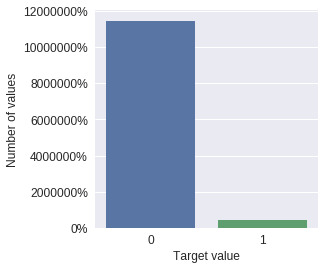

In [23]:
plt.figure()

fig, ax = plt.subplots(figsize=(4,4))
x = trainset['target'].value_counts().index.values
y = trainset["target"].value_counts().values

# Bar plot
    # Order the bars descending on target mean
sns.barplot(ax=ax, x=x, y=y)

# nam
from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(xmax=5))
# /nam

plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Target value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

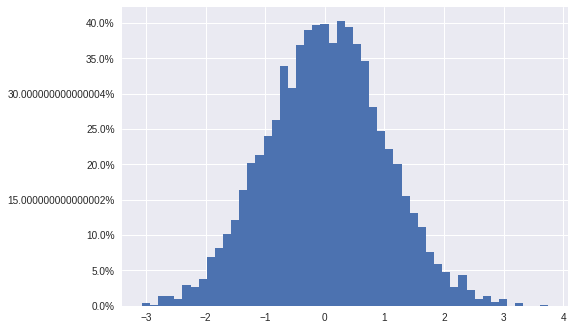

In [24]:
# nam 
# 차트 100% 로 나타내기.. 비율로 보고싶다. 
    # 비율 / 개수 둘 다 보면된다. 
    # 비율로만 볼 경우 문제 : 1. A,B 샘플집단의 갯수가 다를때 (1만개, 30개) -> 오버/언더샘플링?
    # ㄴㄴ . 두 집단간 샘플갯수가 아닌 (타겟값 관련) 클래스 갯수를 맞춰주는것. 

import matplotlib
from numpy.random import randn
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

x = randn(5000)

# Make a normed histogram. It'll be multiplied by 100 later.
plt.hist(x, bins=50, normed=True)

# Create the formatter using the function to_percent. This multiplies all the
# default labels by 100, making them all percentages
formatter = FuncFormatter(to_percent)

# Set the formatter
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

Only 3.64% of the target data have 1 value. 

<mark>**This means that the training dataset is highly imbalanced.** </mark>

We can either **undersample** the records with target = 0, 
or oversample records with target = 1 

; because is a large dataset, we will do undersampling of records with target = 0.

---------













## 5.2 Real features

- ps_car_12 랑 ps_car_15는 특정연산시 정수형 됨. 오오.

In [25]:
variable = metadata[(metadata.type == 'real') & (metadata.preserve)].index
# type이 real이면서 + preserve가 유일하게 false인 id 컬럼만 제외하고 

trainset[variable].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [26]:
# nam
# 아랫셀 뭐하는건지 모르겠어서 탐색
print(trainset['ps_car_12'].head(3))
(pow(trainset['ps_car_12']*10,2)).head(3)
# 10배 후 2승 

0    0.400000
1    0.316228
2    0.316228
Name: ps_car_12, dtype: float64


0    16.0
1    10.0
2    10.0
Name: ps_car_12, dtype: float64

In [27]:
print(trainset.ps_car_15.head(3))
(pow(trainset['ps_car_15'],2)).head(3)

0    3.605551
1    2.449490
2    3.316625
Name: ps_car_15, dtype: float64


0    13.0
1     6.0
2    11.0
Name: ps_car_15, dtype: float64

In [28]:
# nam
usage()

현재 사용 메모리는  1538.7 MB 랍니다.


### 5.2.1 Features with missing values

**ps_reg_03**, **ps_car_12**, **ps_car_14** have missing values (their minimum value is -1)

In [29]:
# nam 
carlist1 = ['ps_reg_03', 'ps_car_12', 'ps_car_14']
df_carlist1=trainset[carlist1]
print(df_carlist1.head())
print(df_carlist1.describe())
# print(df_carlist1.isnull().sum(axis=0))
# print(df_carlist1.isna().sum(axis=0))

# 3배 빠름 > isna(), isnull보다 
# count_nan = len(df_carlist1) - df_carlist1.count()

# df_carlist1.apply(lambda x: x.count(), axis=0)
print(df_carlist1.isnull())

   ps_reg_03  ps_car_12  ps_car_14
0   0.718070   0.400000   0.370810
1   0.766078   0.316228   0.388716
2  -1.000000   0.316228   0.347275
3   0.580948   0.374166   0.294958
4   0.840759   0.316070   0.365103
           ps_reg_03      ps_car_12      ps_car_14
count  595212.000000  595212.000000  595212.000000
mean        0.551102       0.379945       0.276256
std         0.793506       0.058327       0.357154
min        -1.000000      -1.000000      -1.000000
25%         0.525000       0.316228       0.333167
50%         0.720677       0.374166       0.368782
75%         1.000000       0.400000       0.396485
max         4.037945       1.264911       0.636396
        ps_reg_03  ps_car_12  ps_car_14
0           False      False      False
1           False      False      False
2           False      False      False
3           False      False      False
4           False      False      False
5           False      False      False
6           False      False      False
7          

### 5.2.2 Registration features

**ps_reg_01** and **ps_reg_02** are fractions with denominator 10 (values of 0.1, 0.2, 0.3 )


In [30]:
# nam 
carlist = ['ps_reg_01', 'ps_reg_02']
df_carlist1=trainset[carlist1]
print(df_carlist1.head())
df_carlist1.describe()

   ps_reg_03  ps_car_12  ps_car_14
0   0.718070   0.400000   0.370810
1   0.766078   0.316228   0.388716
2  -1.000000   0.316228   0.347275
3   0.580948   0.374166   0.294958
4   0.840759   0.316070   0.365103


,ps_reg_03,ps_car_12,ps_car_14
count,595212.000000,595212.000000,595212.000000
mean,0.551102,0.379945,0.276256
std,0.793506,0.058327,0.357154
min,-1.000000,-1.000000,-1.000000
25%,0.525000,0.316228,0.333167
50%,0.720677,0.374166,0.368782
75%,1.000000,0.400000,0.396485
max,4.037945,1.264911,0.636396



### 5.2.3 Car features _ target => pairplot

**ps_car_12** are (with some approximations) square roots (divided by 10) of natural numbers whilst **ps_car_15** are square roots of natural numbers. Let's represent the values using *pairplot*.

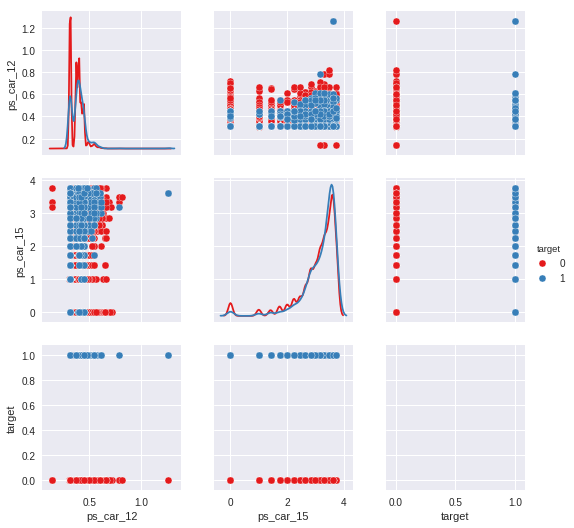

In [31]:


# 데이터 사이언스 스쿨 : Seaborn을 사용한 데이터 분포 시각화
    # 다차원 실수형 데이터
        # 만약 3차원 이상의 데이터라면 seaborn 패키지의 pairplot 명령을 사용한다. 
        # 1. pairplot은 데이터프레임을 인수로 받아 그리드(grid) 형태로 
        # 각 데이터 열의 조합에 대해 스캐터 플롯을 그린다. 
        # 2. 같은 데이터가 만나는 대각선 영역에는 해당 데이터의 히스토그램을 그린다.

# 3개 car 컬럼만 5% 샘플링해서 
sample = trainset.sample(frac=0.05)
var = ['ps_car_12', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample,  hue='target', palette = 'Set1', diag_kind='kde')
plt.show()

### 5.2.4. Calculated features

The features **ps_calc_01**, **ps_calc_02** and **ps_calc_03** have <mark> very similar distributions (타겟값 0,1에 대해) </mark>and could be some kind of ratio, since the maximum value is for all three 0.9. 

The other calculated values have maximum value an integer value (5,6,7, 10,12). 


In [32]:
# nam 
# 5,6,7, 10,12 한번 보기
calc_integer = ['ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_10', 'ps_calc_12']
df_calc_integer = trainset[calc_integer]
print(df_calc_integer.info(),"\n")
print(df_calc_integer.head(),"\n")
print(df_calc_integer.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 5 columns):
ps_calc_05    595212 non-null int64
ps_calc_06    595212 non-null int64
ps_calc_07    595212 non-null int64
ps_calc_10    595212 non-null int64
ps_calc_12    595212 non-null int64
dtypes: int64(5)
memory usage: 22.7 MB
None 

   ps_calc_05  ps_calc_06  ps_calc_07  ps_calc_10  ps_calc_12
0           1          10           1           5           1
1           1           9           5           7           1
2           2           9           1           7           2
3           4           7           1           2           2
4           2           6           3          12           1 

          ps_calc_05     ps_calc_06     ps_calc_07     ps_calc_10  \
count  595212.000000  595212.000000  595212.000000  595212.000000   
mean        1.885886       7.689445       3.005823       8.433590   
std         1.134927       1.334312       1.414564       2.904597   
min         0.

Let's visualize the real features distribution using density plot.

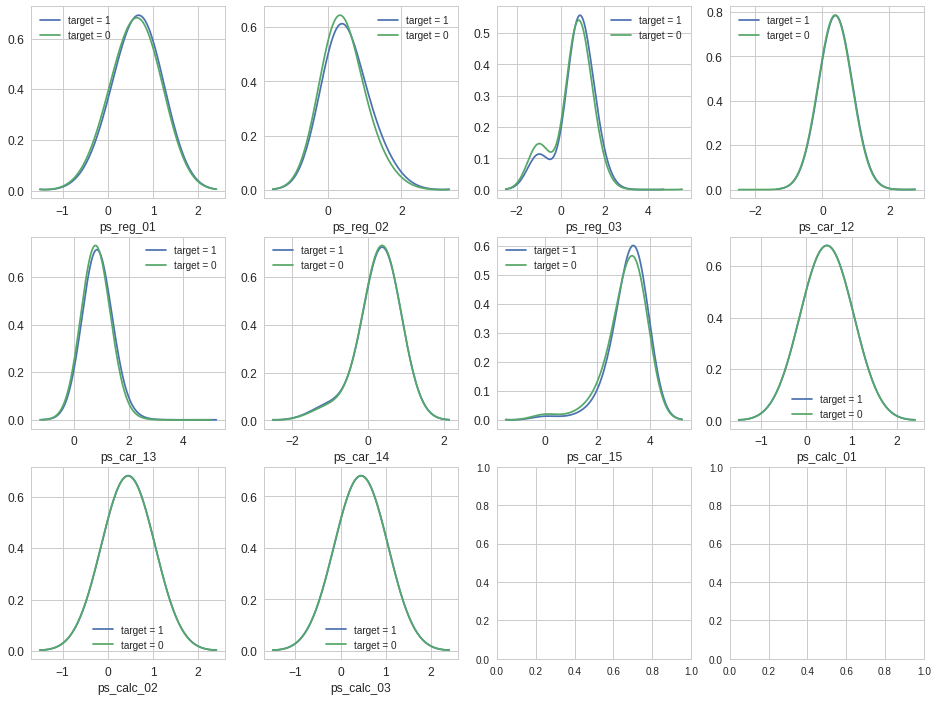

In [33]:
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3,4,figsize=(16,12))

for feature in var:
    i += 1
    plt.subplot(3,4,i)
    sns.kdeplot(t1[feature], bw=0.5,label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5,label="target = 0")
#     plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

<font color = "red"> **ps_reg_02**, **ps_car_13**, **ps_car_15** shows the most different distributions between sets of values associated with `target=0` and `target=1`. </font> 
## ㄴ-> ????? 대체 무슨기준으로.. 쟤네 셋만 다르다는거지

-------
=====


Let's visualize the correlation between the real features

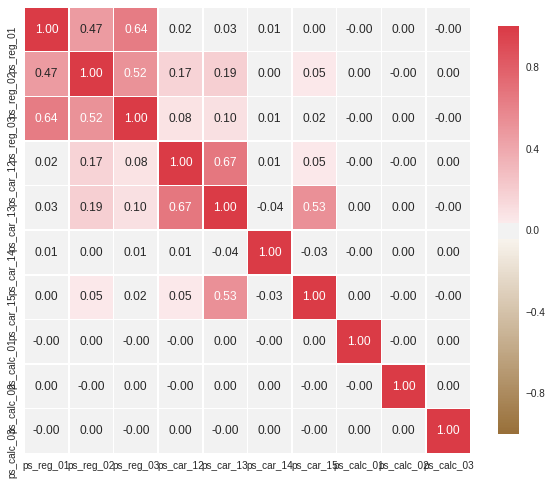

In [35]:
def corr_heatmap(var):
    correlations = trainset[var].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(50, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show();
    
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
corr_heatmap(var)

Let's visualize the plots of the variables with strong correlations. These are:

* ps_reg_01 with ps_reg_02 (0.47);  
* ps_reg_01 with ps_reg_03 (0.64);  
* ps_reg_02 with ps_reg_03 (0.52);  
* ps_car_12 with ps_car_13 (0.67);  
* ps_car_13 with ps_car_15 (0.53);  


- To show the pairs of values that are correlated we use *pairplot*. 
- Before representing the pairs, we **subsample** the data, using only 2% in the sample.



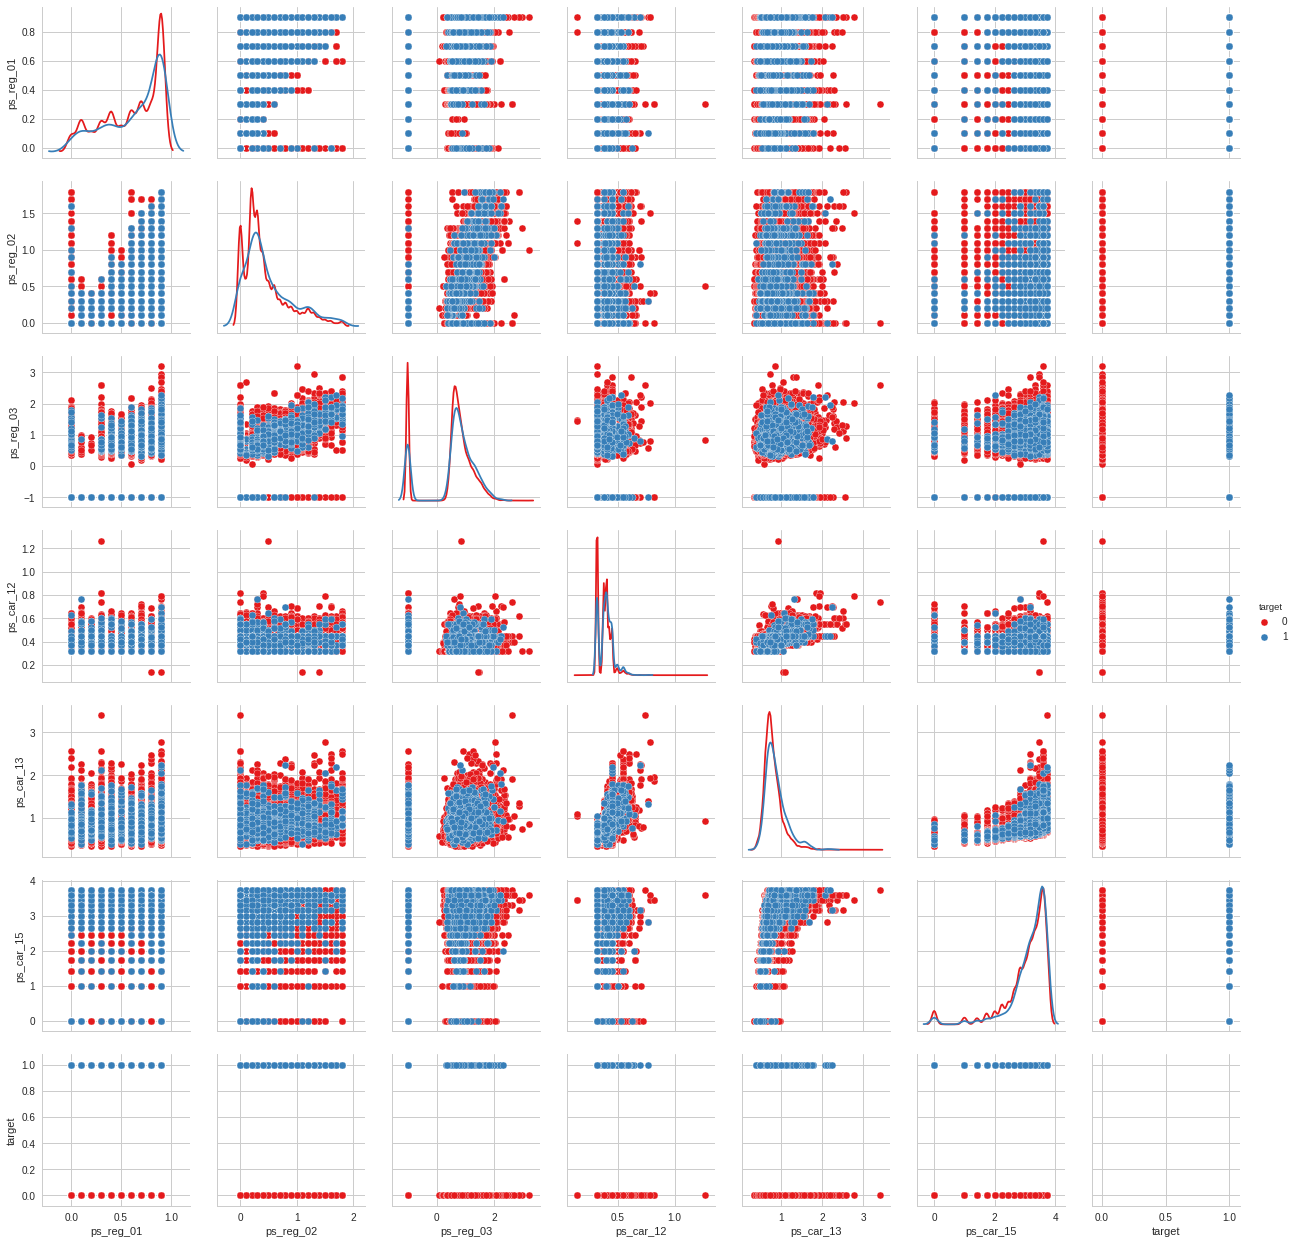

In [36]:
sample = trainset.sample(frac=0.05)
var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample,  hue='target', palette = 'Set1', diag_kind='kde')
plt.show()

In [37]:
usage()

현재 사용 메모리는  1608.0 MB 랍니다.


# 6 Binary features



In [38]:

v = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
trainset[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Let's plot the distribution of the binary data in the training dataset. With `blue` we represent the percent of `0` and with `red` the percent of `1`.

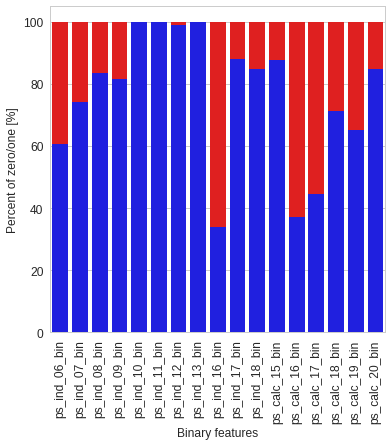

In [39]:
bin_col = [col for col in trainset.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((trainset[col]==0).sum()/trainset.shape[0]*100)
    one_list.append((trainset[col]==1).sum()/trainset.shape[0]*100)
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
# Bar plot
p1 = sns.barplot(ax=ax, x=bin_col, y=zero_list, color="blue")
p2 = sns.barplot(ax=ax, x=bin_col, y=one_list, bottom= zero_list, color="red")
plt.ylabel('Percent of zero/one [%]', fontsize=12)
plt.xlabel('Binary features', fontsize=12)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend((p1, p2), ('Zero', 'One'))
plt.show();

**ps_ind_10_bin**, **ps_ind_11_bin**, **ps_ind_12_bin** and **ps_ind_13_bin** have very small number of  values `1` (lesss than 0.5%) whilst the number of  value `1` is very large for **ps_ind_16_bin** and **ps_cals_16_bin** (more than 60%).

Let's see now the distribution of binary data and the corresponding values of **target** variable.


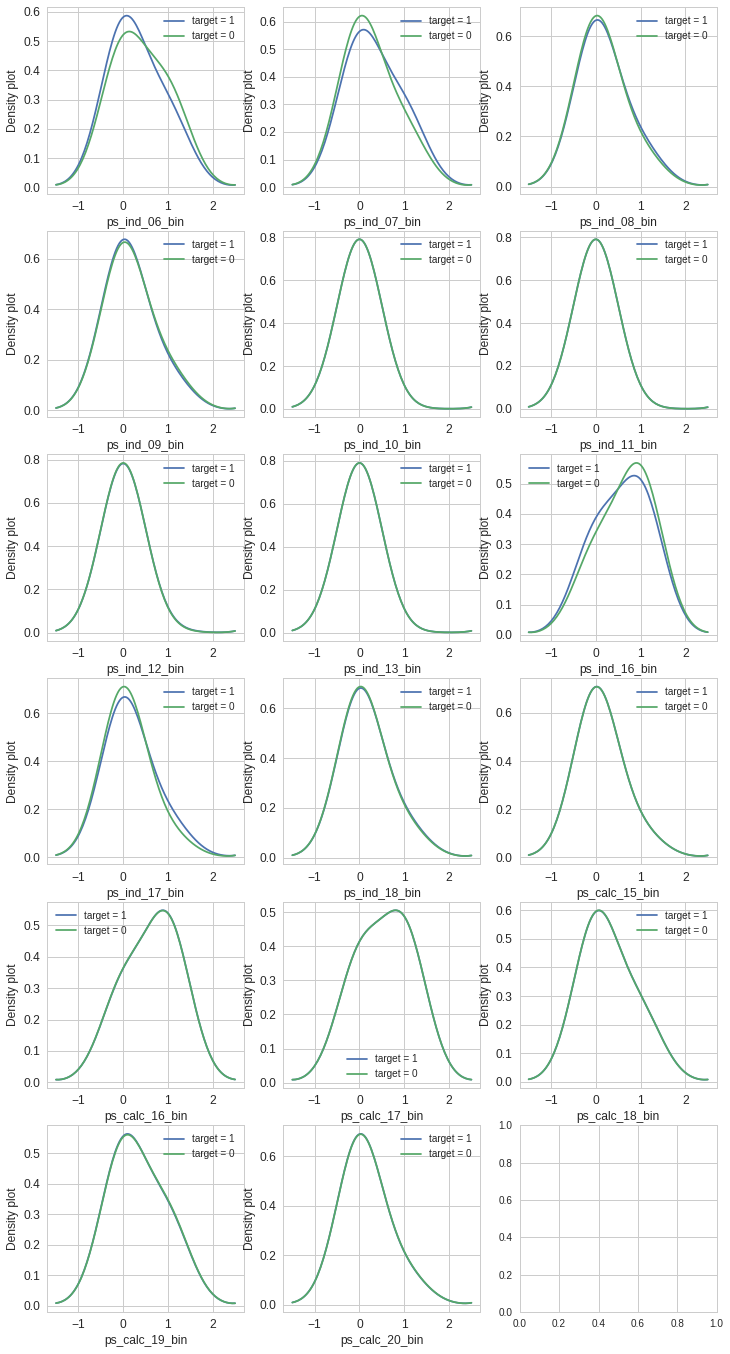

In [40]:
var = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
var = [col for col in trainset.columns if '_bin' in col]
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(6,3,figsize=(12,24))

for feature in var:
    i += 1
    plt.subplot(6,3,i)
    sns.kdeplot(t1[feature], bw=0.5,label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5,label="target = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

**ps_ind_06_bin**, **ps_ind_07_bin**, **ps_ind_16_bin**, **ps_ind_17_bin**  shows high inbalance between distribution of values of `1` and `0` for values of target equals with `1` and `0`, **ps_ind_08_bin** shows a small inbalance while the other features are well balanced, having similar density plots.

## 6.1 Categorical features

We will represent the distribution on `categorical` data in two ways. 
First, we calculate the percentage of `target=1` per category value and represent these percentages
using bar plots.

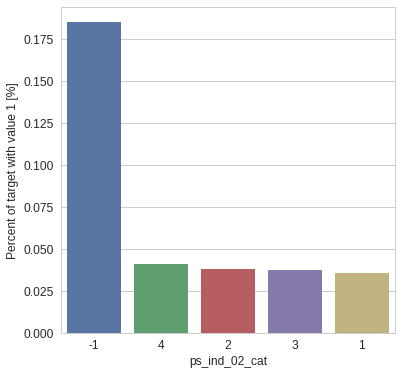

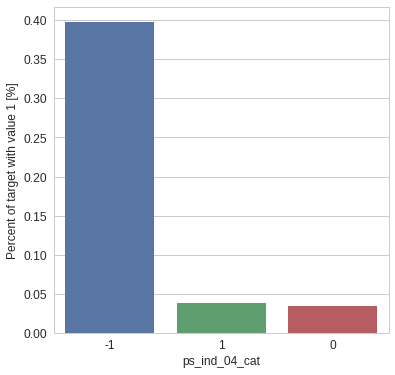

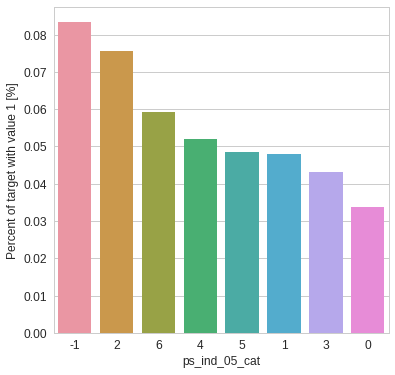

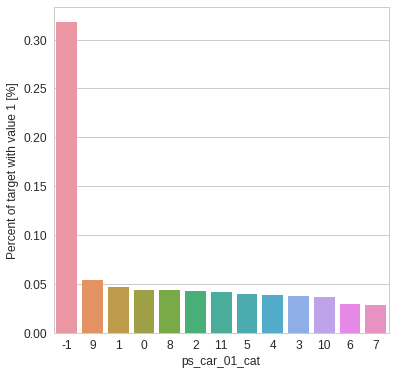

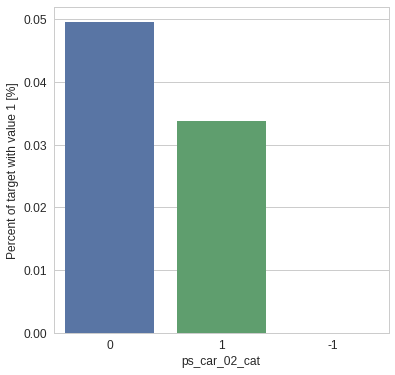

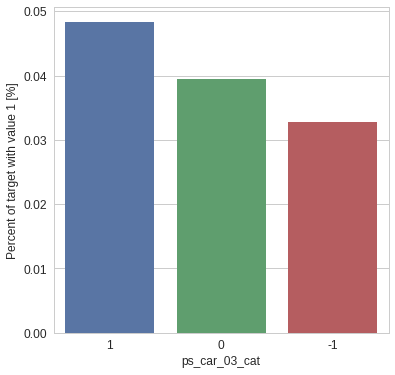

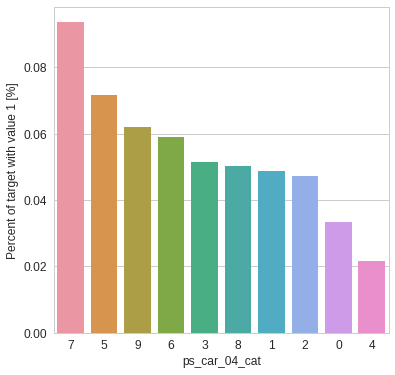

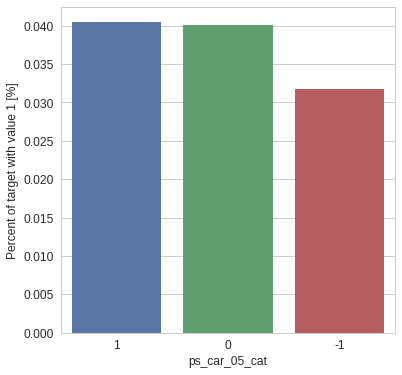

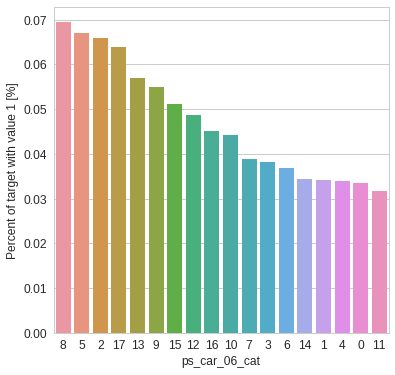

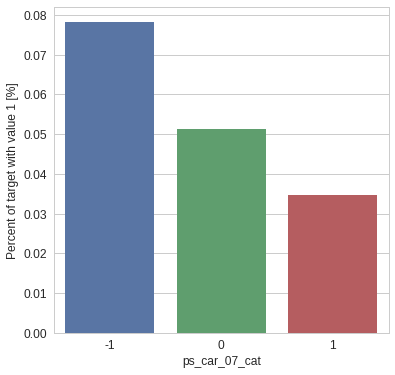

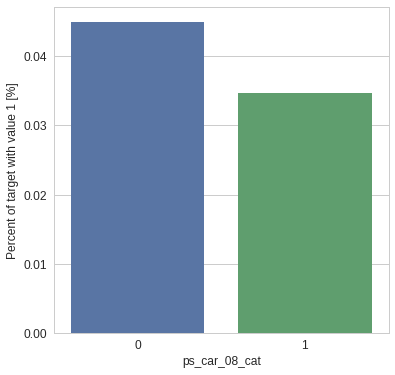

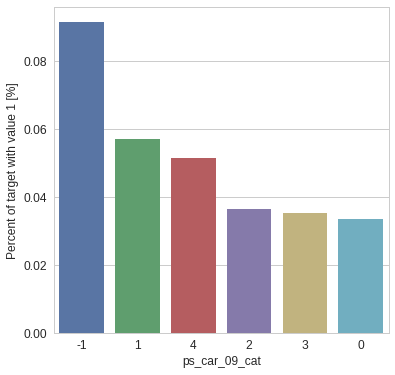

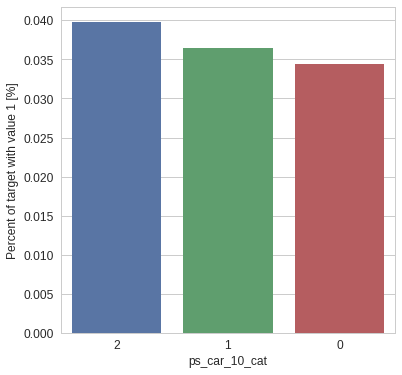

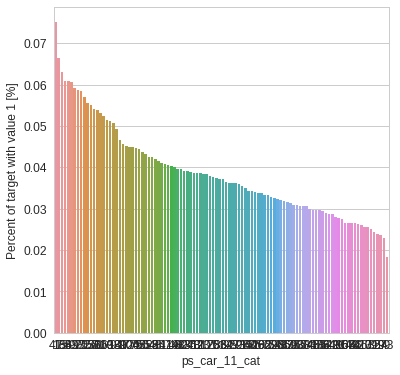

In [41]:
var = metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

for feature in var:
    fig, ax = plt.subplots(figsize=(6,6))
    # Calculate the percentage of target=1 per category value
    cat_perc = trainset[[feature, 'target']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # Bar plot
    # Order the bars descending on target mean
    sns.barplot(ax=ax,x=feature, y='target', data=cat_perc, order=cat_perc[feature])
    plt.ylabel('Percent of target with value 1 [%]', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

Alternativelly we represent the `categorical` features using density plot. We select values with `target=0` and `target=1` and represent both density plots on the same graphic.

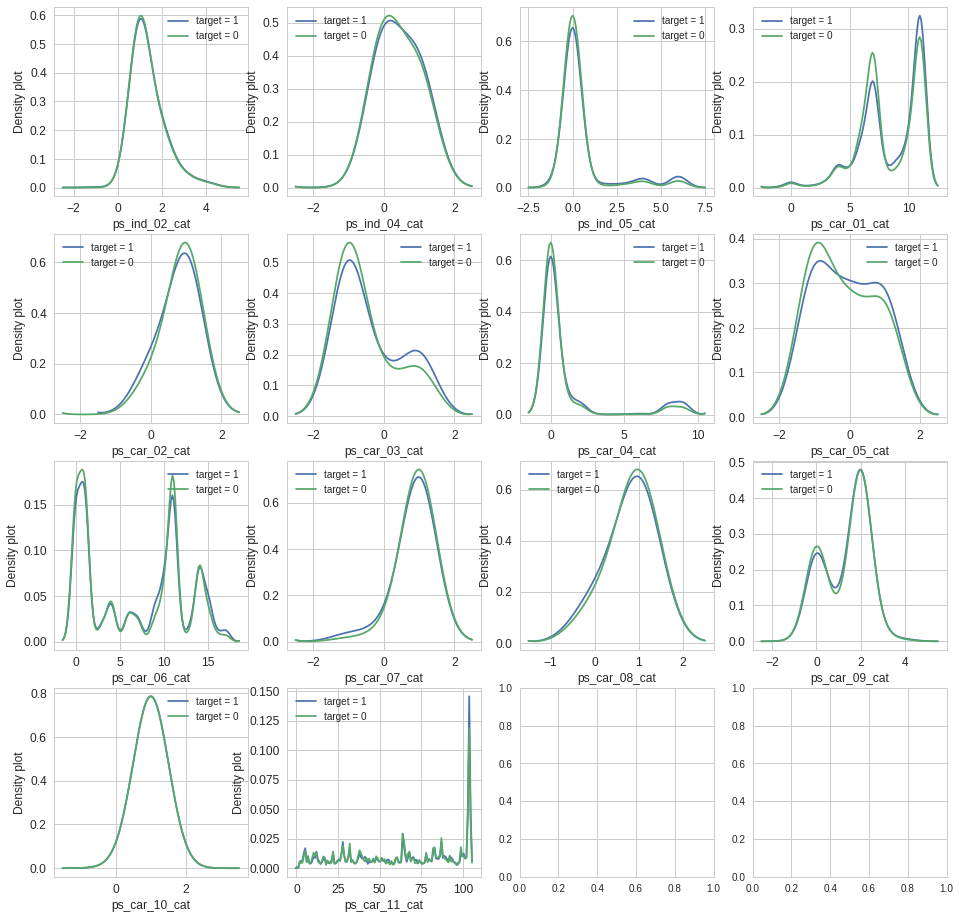

In [42]:
var = metadata[(metadata.type == 'categorical') & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(4,4,figsize=(16,16))

for feature in var:
    i += 1
    plt.subplot(4,4,i)
    sns.kdeplot(t1[feature], bw=0.5,label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5,label="target = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

**ps_car_03_cat**, **ps_car_05_cat** shows the most different density plot between values associated with `target=0` and `target=1`.

## 6.2 Data unbalance between train and test data 

Let's compare the distribution of the features in the train and test datasets. 

We start with the `reg` or `registration` features.

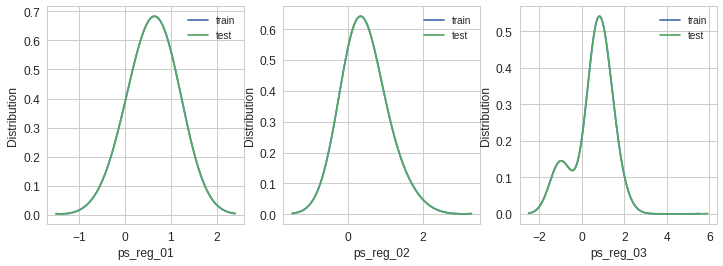

In [43]:
var = metadata[(metadata.category == 'registration') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(1,3,figsize=(12,4))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(1,3,i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

All `reg` features shows well balanced train and test sets.

Let's continue with `car` features.

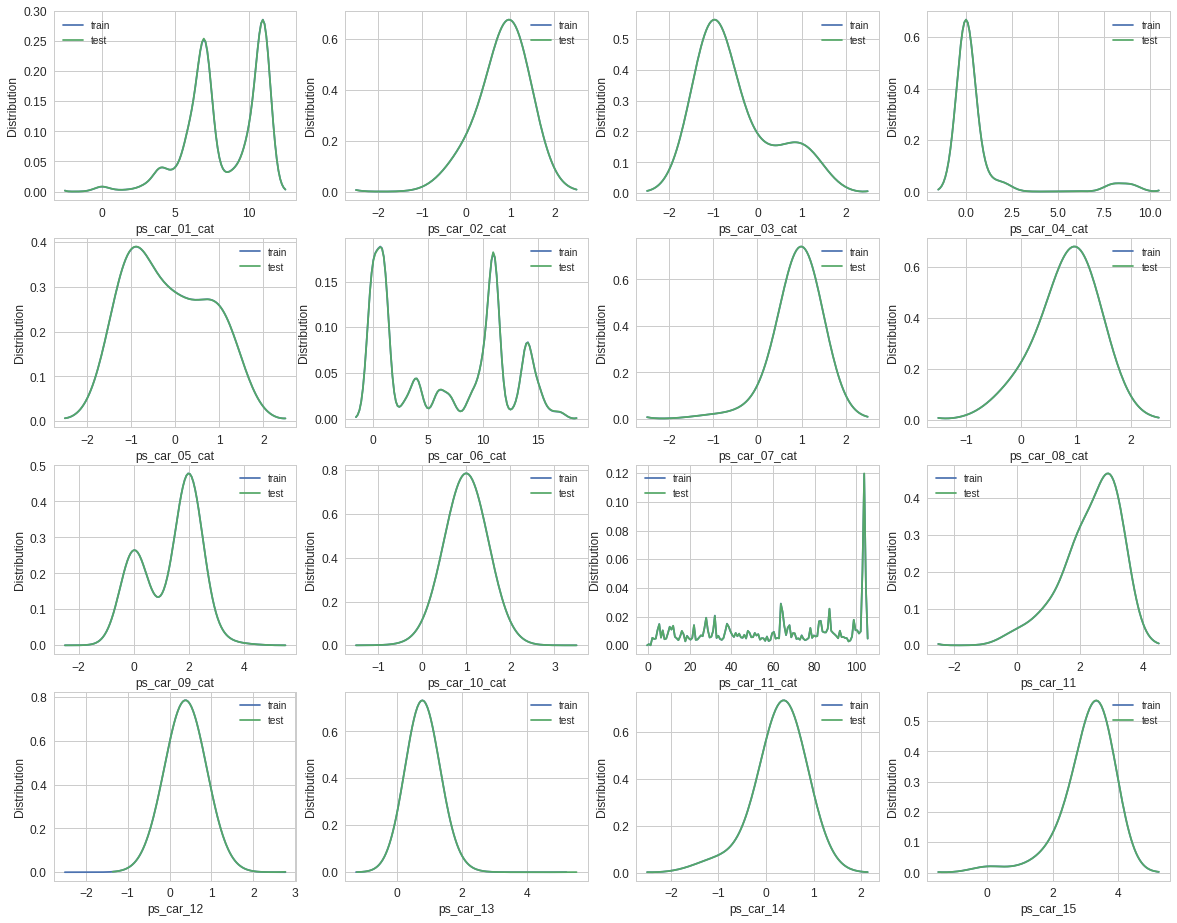

In [44]:
var = metadata[(metadata.category == 'car') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(4,4,figsize=(20,16))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(4,4,i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

From the `car` features, all variables looks well balanced between `train` and `test` set.

Let's look now to the `ind` (`individual`) values.

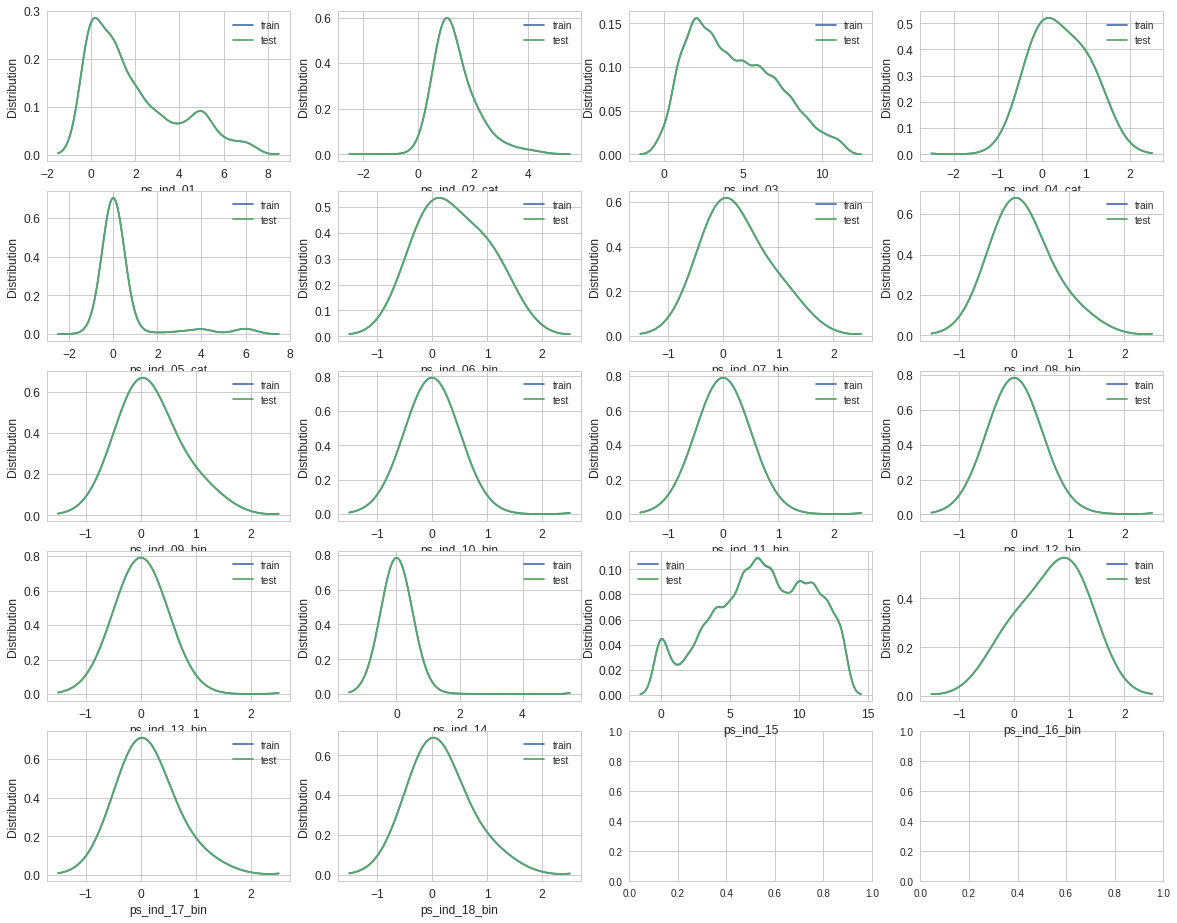

In [45]:
var = metadata[(metadata.category == 'individual') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(5,4,figsize=(20,16))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(5,4,i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

All `ind` features are well balanced between `train` and `test` sets.

Let's check now `calc` features.

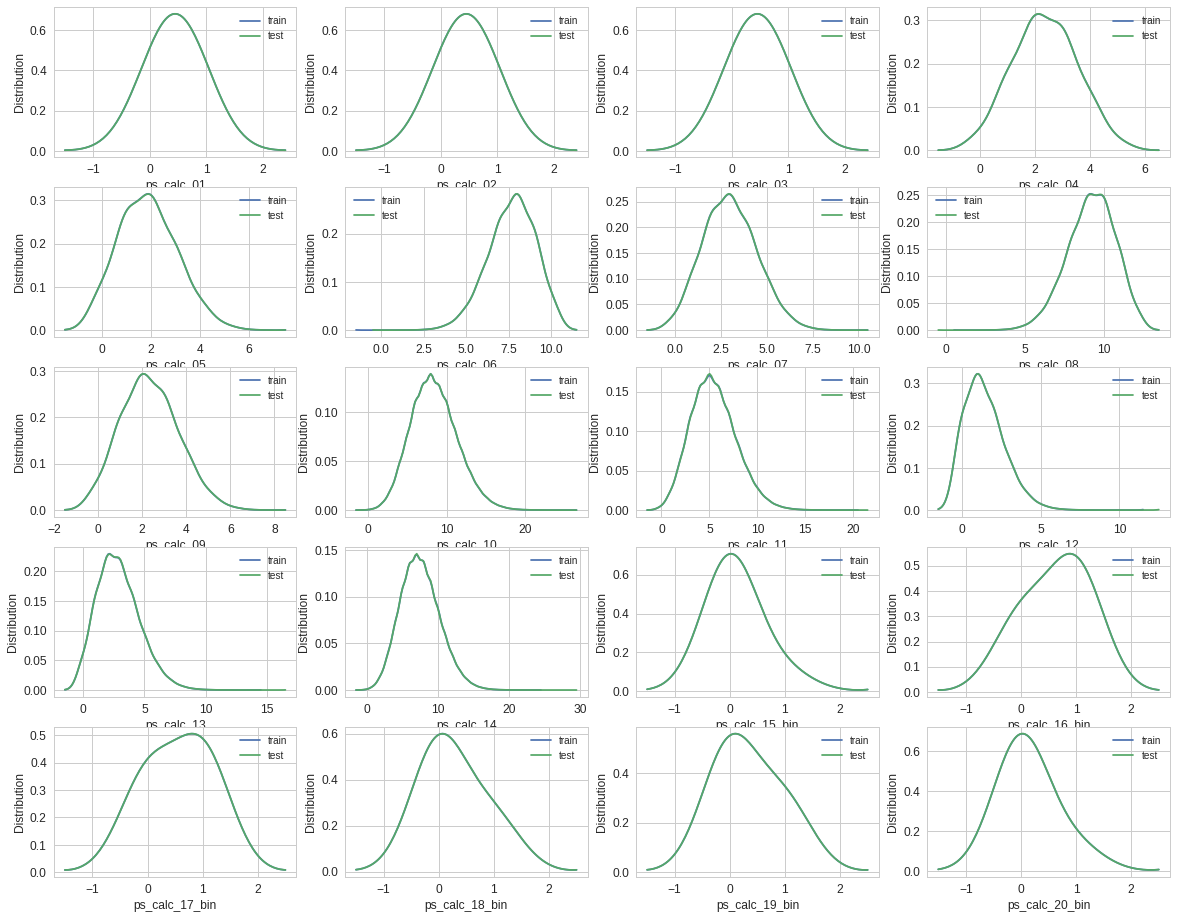

In [46]:
var = metadata[(metadata.category == 'calculated') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(5,4,figsize=(20,16))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(5,4,i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

All `calc` features are well balanced between `train` and `test` sets. 

In reference [5] it is also noticed the well balancing between `train` and `test` sets. It is also suggested that `calc` features might be all engineered and actually not relevant. This can only be assesed by careful succesive elimination using `CV` score using one or more predictive models.



# 7 Check data quality

Let's inspect the features with missing values:

In [47]:
vars_with_missing = []

for feature in trainset.columns:
    missings = trainset[trainset[feature] == -1][feature].count()
    if missings > 0:
        vars_with_missing.append(feature)
        missings_perc = missings/trainset.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(feature, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
Variable ps_car_07_cat has 11489 records (1.93%) with missing values
Variable ps_car_09_cat has 569 records (0.10%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_12 has 1 records (0.00%) with missing values
Variable ps_car_14 has 42620 records (7.16%) with missing values
In total, there are 13 variables with missing values


# 8 Prepare the data for model





### Drop **calc** columns

We also drop the **calc** columns, as recommended in [5]. These seems to be all engineered and, according to Dmitry Altukhov, he was able to improve his CV score while succesivelly removing all of them.


In [0]:
col_to_drop = trainset.columns[trainset.columns.str.startswith('ps_calc_')]
trainset = trainset.drop(col_to_drop, axis=1)  
testset = testset.drop(col_to_drop, axis=1)  

### Drop variables with too many missing values

We select from the variables with missing values two, **ps_car_03_cat** and **ps_car_05_cat** to drop.

In [0]:
# Dropping the variables with too many missing values
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
trainset.drop(vars_to_drop, inplace=True, axis=1)
testset.drop(vars_to_drop, inplace=True, axis=1)
metadata.loc[(vars_to_drop),'keep'] = False  # Updating the meta


In [0]:
# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

### Replace ps_car_11_cat with encoded value

Using the **target_encode** function, we replace the **ps_car_11_cat** with an encoded value in both **train** and **test** datasets.



In [0]:
train_encoded, test_encoded = target_encode(trainset["ps_car_11_cat"], 
                             testset["ps_car_11_cat"], 
                             target=trainset.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)
    
trainset['ps_car_11_cat_te'] = train_encoded
trainset.drop('ps_car_11_cat', axis=1, inplace=True)
metadata.loc['ps_car_11_cat','keep'] = False  # Updating the metadata
testset['ps_car_11_cat_te'] = test_encoded
testset.drop('ps_car_11_cat', axis=1, inplace=True)

### Balance target variable

The target variable is highly unbalanced. This can be improved by either undersampling values with **target = 0** or oversampling values with **target = 1**.  Because there is a rather large training set, we opt for the **undersampling**.

In [52]:
desired_apriori=0.10

# Get the indices per target value
idx_0 = trainset[trainset.target == 0].index
idx_1 = trainset[trainset.target == 1].index

# Get original number of records per target value
nb_0 = len(trainset.loc[idx_0])
nb_1 = len(trainset.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=314, n_samples=undersampled_nb_0)

# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

# Return undersample data frame
trainset = trainset.loc[idx_list].reset_index(drop=True)


Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


### Replace **-1** values with NaN

Most of the classifiers we would use have preety good strategies to manage missing (or NaN) values.


In [0]:
trainset = trainset.replace(-1, np.nan)
testset = testset.replace(-1, np.nan)

### Dummify **cat** values

We will create dummy variables for the **categorical** (**cat**) features


In [0]:
cat_features = [a for a in trainset.columns if a.endswith('cat')]

for column in cat_features:
    temp = pd.get_dummies(pd.Series(trainset[column]))
    trainset = pd.concat([trainset,temp],axis=1)
    trainset = trainset.drop([column],axis=1)
    
for column in cat_features:
    temp = pd.get_dummies(pd.Series(testset[column]))
    testset = pd.concat([testset,temp],axis=1)
    testset = testset.drop([column],axis=1)

### Drop unused and **target** columns

We separate the **id** and **target** (drop these columns)

In [0]:
id_test = testset['id'].values
target_train = trainset['target'].values

trainset = trainset.drop(['target','id'], axis = 1)
testset = testset.drop(['id'], axis = 1)

Let's inspect the training and test sets:

In [56]:
print("Train dataset (rows, cols):",trainset.values.shape, "\nTest dataset (rows, cols):",testset.values.shape)

Train dataset (rows, cols): (216940, 91) 
Test dataset (rows, cols): (892816, 91)


# 9 Prepare the model

### Ensable class for cross validation and ensamble

Prepare an **Ensamble** class to split the data in KFolds, train the models and ensamble the results.

The class has an 2 methods - 

#### 1st method; init

**init** method (called when an Ensamble object is created) that accepts **4 parameters:**

* **self** - the object to be initialized  
* **n_splits** - the number of cross-validation splits to be used  
* **stacker** - the model used for stacking the prediction results from the trained base models    
* **base_models** - the list of base models used in training  

#### 2nd method; fit_predict

A 2nd method, **fit_predict** has **4 functions:**
* split the training data in **n_splits** folds;  
* run the **base models** for each fold;  
* perform prediction using each model;  
* ensamble the resuls using the **stacker**;  




In [0]:
class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models

    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=314).split(X, y))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):

            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]


                print ("Base model %d: fit %s model | fold %d" % (i+1, str(clf).split('(')[0], j+1))
                clf.fit(X_train, y_train)
                cross_score = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
                print("cross_score [roc-auc]: %.5f [gini]: %.5f" % (cross_score.mean(), 2*cross_score.mean()-1))
                y_pred = clf.predict_proba(X_holdout)[:,1]                

                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            S_test[:, i] = S_test_i.mean(axis=1)

        results = cross_val_score(self.stacker, S_train, y, cv=3, scoring='roc_auc')
        # Calculate gini factor as 2 * AUC - 1
        print("Stacker score [gini]: %.5f" % (2 * results.mean() - 1))

        self.stacker.fit(S_train, y)
        res = self.stacker.predict_proba(S_test)[:,1]
        return res

### Parameters for the base models

For the base models, we prepare 

- **3 different LightGBM models and** 
- **1 XGB model.**  


Each model is used to train the data (using as well cross-validation, with **3** folds).


In [0]:
# XGBoost params
xgb_params = {}
xgb_params['objective'] = 'binary:logistic'
xgb_params['learning_rate'] = 0.04
xgb_params['n_estimators'] = 490
xgb_params['max_depth'] = 4
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9  
xgb_params['min_child_weight'] = 10
xgb_params['num_threads'] = 4

# LightGBM params
# lgb_1
lgb_params1 = {}
lgb_params1['learning_rate'] = 0.02
lgb_params1['n_estimators'] = 650
lgb_params1['max_bin'] = 10
lgb_params1['subsample'] = 0.8
lgb_params1['subsample_freq'] = 10
lgb_params1['colsample_bytree'] = 0.8   
lgb_params1['min_child_samples'] = 500
lgb_params1['seed'] = 314
lgb_params1['num_threads'] = 4

# lgb2
lgb_params2 = {}
lgb_params2['n_estimators'] = 1090
lgb_params2['learning_rate'] = 0.02
lgb_params2['colsample_bytree'] = 0.3   
lgb_params2['subsample'] = 0.7
lgb_params2['subsample_freq'] = 2
lgb_params2['num_leaves'] = 16
lgb_params2['seed'] = 314
lgb_params2['num_threads'] = 4

# lgb3
# parameter 생성 : num_leaves / 2^{(max_depth)-1}
lgb_params3['num_leaves'] = 8
lgb_params3['n_estimators'] = 1100
lgb_params3['max_depth'] = 4
lgb_params3['n_estimators'] = 1100
lgb_params3['learning_rate'] = 0.02
lgb_params3['seed'] = 314
lgb_params3['num_threads'] = 4



### Initialize the models with the parameters

We init the 3 base models and the stacking model. For the base models we are using the predefined parameters initialized above.



In [59]:
usage()

현재 사용 메모리는  5291.5 MB 랍니다.


In [0]:
# Base models
lgb_model1 = LGBMClassifier(**lgb_params1)

lgb_model2 = LGBMClassifier(**lgb_params2)
       
lgb_model3 = LGBMClassifier(**lgb_params3)

xgb_model = XGBClassifier(**xgb_params)

# Stacking model
log_model = LogisticRegression()

### Initialize the ensambling object

Using Ensamble.init we init the stacking object


In [61]:
usage()

현재 사용 메모리는  5291.5 MB 랍니다.


In [0]:
stack = Ensemble(n_splits=3,
        stacker = log_model,
        base_models = (lgb_model1, lgb_model2, lgb_model3, xgb_model))  

# 10 Run the predictive models

Calling the **fit_predict** method of **stack** object, we run the training of the base models, predict the **target** with each model, ensamble the results using the **stacker** model and output the stacked result.


In [63]:
y_prediction = stack.fit_predict(trainset, target_train, testset)        

Base model 1: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.63605 [gini]: 0.27210
Base model 1: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.63909 [gini]: 0.27819
Base model 1: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.63640 [gini]: 0.27280
Base model 2: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.63711 [gini]: 0.27423
Base model 2: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.64004 [gini]: 0.28008
Base model 2: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.63720 [gini]: 0.27441
Base model 3: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.63523 [gini]: 0.27045
Base model 3: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.63720 [gini]: 0.27439
Base model 3: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.63443 [gini]: 0.26886
Base model 4: fit XGBClassifier model | fold 1
cross_score [roc-auc]: 0.63684 [gini]: 0.27369
Base model 4: fit XGBClassifier model | fold 2
cros

# 11 Prepare the submission


In [0]:
submission = pd.DataFrame()
submission['id'] = id_test
submission['target'] = y_prediction
submission.to_csv('stacked.csv', index=False)

# References

[1] Porto Seguro Safe Driver Prediction, Kaggle Competition, https://www.kaggle.com/c/porto-seguro-safe-driver-prediction   
[2] Bert Carremans, Data Preparation and Exploration, Kaggle Kernel, https://www.kaggle.com/bertcarremans/data-preparation-exploration   
[3] Head or Tails, Steering Whell of Fortune - Porto Seguro EDA, Kaggle Kernel, https://www.kaggle.com/headsortails/steering-wheel-of-fortune-porto-seguro-eda   
[4] Anisotropic, Interactive Porto Insights - A Plot.ly Tutorial, Kaggle Kernel, https://www.kaggle.com/arthurtok/interactive-porto-insights-a-plot-ly-tutorial  
[5] Dmitry Altukhov, Kaggle Porto Seguro's Safe Driver Prediction (3rd place solution),  https://www.youtube.com/watch?v=mbxZ_zqHV9c  
[6] Vladimir Demidov, Simple Staker LB 0.284, https://www.kaggle.com/yekenot/simple-stacker-lb-0-284  
[7] Anisotropic, Introduction to Ensembling/Stacking in Python, https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python  




# Feedback

I will appreciate your suggestions and observations.